# Sudoku Neural Network RL Fine-Tuning

Fine-tuning pre-trained Sudoku model using EGGROLL gradient-free reinforcement learning

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nn import SudokuNet, load_kaggle_data
from symbolic_layer import ArgmaxLayer
from environment import SudokuRLEnv
from rl_optimizer import EggrollOptimizer

## 1. Load and Prepare Data

Download the dataset from: https://www.kaggle.com/datasets/bryanpark/sudoku

Place `sudoku.csv` in the same directory as this notebook.

In [2]:
# Load data (use fewer samples for faster RL experimentation)
puzzles, solutions = load_kaggle_data('sudoku.csv', max_samples=10000)

print(f"Loaded {len(puzzles)} puzzles")
print(f"Example puzzle:  {puzzles[0]}")
print(f"Example solution: {solutions[0]}")

Loaded 10000 puzzles
Example puzzle:  004300209005009001070060043006002087190007400050083000600000105003508690042910300
Example solution: 864371259325849761971265843436192587198657432257483916689734125713528694542916378


In [3]:
# Split into train/validation
train_puzzles, val_puzzles, train_solutions, val_solutions = train_test_split(
    puzzles, solutions, test_size=0.2, random_state=834
)

print(f"Training samples: {len(train_puzzles)}")
print(f"Validation samples: {len(val_puzzles)}")

Training samples: 8000
Validation samples: 2000


## 2. Load Pre-trained Model

In [4]:
# Load the pre-trained model from supervised training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SudokuNet(hidden_sizes=[256, 256, 256])
model = model.to(device)

# Load checkpoint
checkpoint = torch.load('sudoku_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Model loaded from sudoku_model.pth")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Device: {device}")

Model loaded from sudoku_model.pth
Model has 339,929 parameters
Device: cuda


## 3. Setup RL Environment and Optimizer

In [5]:
# Create symbolic layer (using simple Argmax for now)
symbolic_layer = ArgmaxLayer()

# Create RL environment
env = SudokuRLEnv(model, symbolic_layer, device=device)

# Create EGGROLL optimizer
optimizer = EggrollOptimizer(
    env=env,
    param_groups=model.parameters(),
    population_size=20,      # Number of perturbations per step
    sigma=0.01,              # Noise standard deviation
    learning_rate=0.001,     # Update step size
    rank=4,                  # Low-rank approximation rank
    seed=42
)

print("RL Environment and EGGROLL Optimizer initialized")
print(f"Population size: {optimizer.population_size}")
print(f"Sigma: {optimizer.sigma}")
print(f"Learning rate: {optimizer.lr}")
print(f"Rank: {optimizer.rank}")

RL Environment and EGGROLL Optimizer initialized
Population size: 20
Sigma: 0.01
Learning rate: 0.001
Rank: 4


## 4. RL Fine-Tuning Training Loop

In [6]:
# Training hyperparameters
epochs = 5
batch_size = 32  # Batch size for RL training

# Tracking metrics
train_rewards = []
val_rewards = []
train_accuracies = []
val_accuracies = []

print(f"Starting RL Fine-Tuning for {epochs} epochs")
print(f"Batch size: {batch_size}")
print()

Starting RL Fine-Tuning for 5 epochs
Batch size: 32



In [7]:
from tqdm import tqdm

for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_train_rewards = []
    epoch_train_accs = []
    
    # Sample batches for training
    n_batches = len(train_puzzles) // batch_size
    indices = np.random.permutation(len(train_puzzles))
    
    for i in tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{epochs} - Training"):
        batch_idx = indices[i * batch_size:(i + 1) * batch_size]
        batch_puzzles = [train_puzzles[j] for j in batch_idx]
        batch_solutions = [train_solutions[j] for j in batch_idx]
        
        # EGGROLL optimization step
        max_reward, _ = optimizer.step(batch_puzzles, batch_solutions)
        
        # Track metrics
        epoch_train_rewards.append(max_reward)
        
    # Validation phase
    model.eval()
    epoch_val_rewards = []
    epoch_val_accs = []
    
    # Evaluate on validation set (sample a subset for speed)
    val_sample_size = min(200, len(val_puzzles))
    val_indices = np.random.choice(len(val_puzzles), val_sample_size, replace=False)
    
    for idx in val_indices:
        reward, board, metrics = env.evaluate(val_puzzles[idx], val_solutions[idx])
        epoch_val_rewards.append(reward)
        epoch_val_accs.append(metrics.get('accuracy', 0.0))
    
    # Compute epoch statistics
    avg_train_reward = np.mean(epoch_train_rewards)
    avg_val_reward = np.mean(epoch_val_rewards)
    avg_val_acc = np.mean(epoch_val_accs)
    
    train_rewards.append(avg_train_reward)
    val_rewards.append(avg_val_reward)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Reward: {avg_train_reward:.4f}")
    print(f"  Val Reward: {avg_val_reward:.4f}")
    print(f"  Val Accuracy: {avg_val_acc:.4f} ({avg_val_acc*100:.2f}%)")
    print()

Epoch 1/5 - Training: 100%|██████████| 250/250 [00:49<00:00,  5.05it/s]


Epoch 1/5
  Train Reward: 0.4872
  Val Reward: 0.4851
  Val Accuracy: 0.4851 (48.51%)



Epoch 2/5 - Training: 100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


Epoch 2/5
  Train Reward: 0.4843
  Val Reward: 0.4819
  Val Accuracy: 0.4819 (48.19%)



Epoch 3/5 - Training: 100%|██████████| 250/250 [00:52<00:00,  4.80it/s]


Epoch 3/5
  Train Reward: 0.4846
  Val Reward: 0.4833
  Val Accuracy: 0.4833 (48.33%)



Epoch 4/5 - Training: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s]


Epoch 4/5
  Train Reward: 0.4845
  Val Reward: 0.4821
  Val Accuracy: 0.4821 (48.21%)



Epoch 5/5 - Training: 100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


Epoch 5/5
  Train Reward: 0.4842
  Val Reward: 0.4881
  Val Accuracy: 0.4881 (48.81%)



## 5. Visualize Training Progress

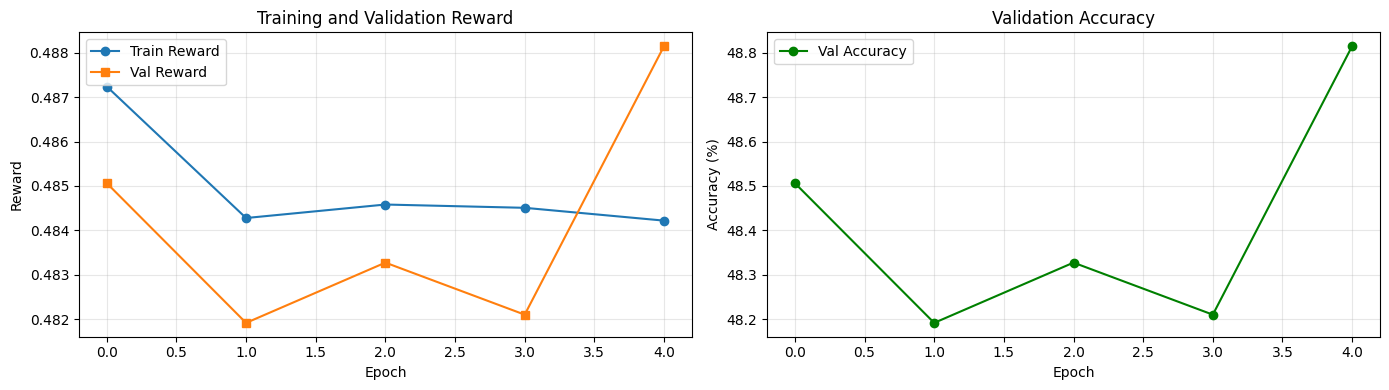

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot rewards
ax1.plot(train_rewards, label='Train Reward', marker='o')
ax1.plot(val_rewards, label='Val Reward', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Reward')
ax1.set_title('Training and Validation Reward')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot([acc * 100 for acc in val_accuracies], label='Val Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Test Predictions

In [9]:
def visualize_sudoku(puzzle_str, title="Sudoku"):
    """Visualize a sudoku puzzle."""
    puzzle = [int(c) for c in puzzle_str]
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i in range(9):
        for j in range(9):
            val = puzzle[i * 9 + j]
            if val != 0:
                ax.text(j + 0.5, 8.5 - i, str(val), 
                       ha='center', va='center', fontsize=16,
                       color='black' if val != 0 else 'gray')
    
    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=lw)
        ax.axvline(i, color='black', linewidth=lw)
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

Puzzle:


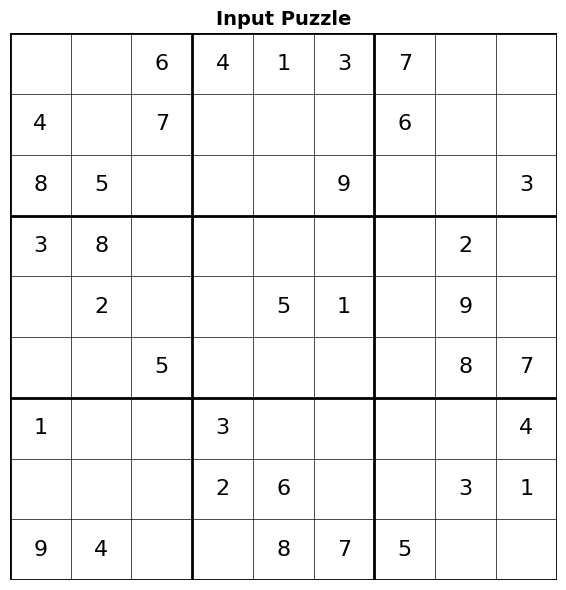


RL Fine-tuned Prediction:


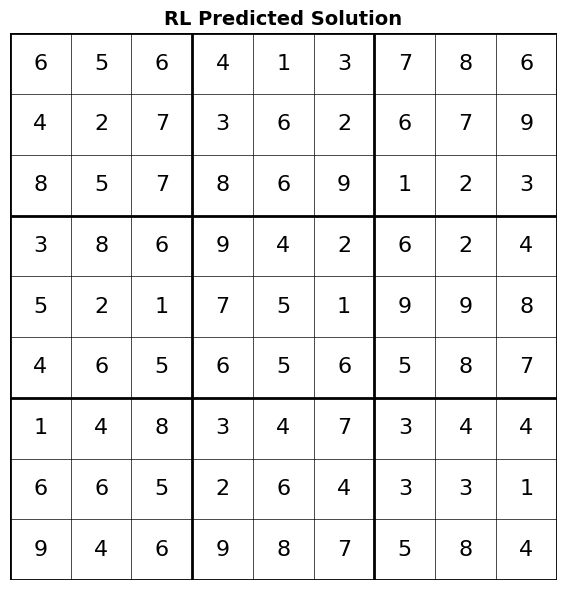


Ground Truth:


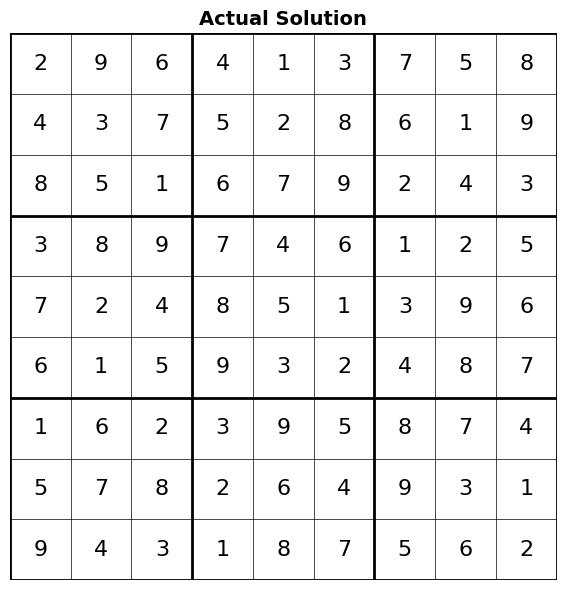


Cells correct: 37/81 (45.7%)
Reward: 0.4568
Metrics: {'nn_mean_conf': 0.9999597072601318, 'nn_min_conf': 0.9967305660247803, 'nn_logits_std': 2517.65478515625, 'symbolic_corrections': 32, 'accuracy': np.float64(0.4567901234567901)}


In [10]:
# Test on a validation example using the RL environment
idx = 0
test_puzzle = val_puzzles[idx]
test_solution = val_solutions[idx]

# Use the environment to get prediction
reward, predicted_board, metrics = env.evaluate(test_puzzle, test_solution)
prediction = ''.join(str(int(c)) for c in predicted_board.flatten())

print("Puzzle:")
visualize_sudoku(test_puzzle, "Input Puzzle")
plt.show()

print("\nRL Fine-tuned Prediction:")
visualize_sudoku(prediction, "RL Predicted Solution")
plt.show()

print("\nGround Truth:")
visualize_sudoku(test_solution, "Actual Solution")
plt.show()

# Calculate accuracy
correct = sum(p == s for p, s in zip(prediction, test_solution))
print(f"\nCells correct: {correct}/81 ({correct/81*100:.1f}%)")
print(f"Reward: {reward:.4f}")
print(f"Metrics: {metrics}")

## 7. Save/Load Fine-tuned Model

In [11]:
# Save the RL fine-tuned model
torch.save({
    'model_state_dict': model.state_dict(),
    'train_rewards': train_rewards,
    'val_rewards': val_rewards,
    'val_accuracies': val_accuracies,
    'optimizer_config': {
        'population_size': optimizer.population_size,
        'sigma': optimizer.sigma,
        'learning_rate': optimizer.lr,
        'rank': optimizer.rank
    }
}, 'sudoku_model_rl_finetuned.pth')

print("RL fine-tuned model saved to sudoku_model_rl_finetuned.pth")

RL fine-tuned model saved to sudoku_model_rl_finetuned.pth


In [12]:
# Load a fine-tuned model
# new_model = SudokuNet(hidden_sizes=[256, 256, 256])
# checkpoint = torch.load('sudoku_model_rl_finetuned.pth', map_location=device)
# new_model.load_state_dict(checkpoint['model_state_dict'])
# print("Loaded fine-tuned model")

## 8. Analyze Performance Improvements

Compare the RL fine-tuned model with the original supervised model

In [13]:
from utils import count_violations

def check_constraints(solution_str):
    """Check if a solution satisfies Sudoku constraints."""
    solution = [int(c) for c in solution_str]
    board = [[solution[i*9 + j] for j in range(9)] for i in range(9)]
    
    violations = {'row': 0, 'col': 0, 'box': 0}
    
    # Check rows
    for row in board:
        if len(set(row)) != 9:
            violations['row'] += 1
    
    # Check columns
    for j in range(9):
        col = [board[i][j] for i in range(9)]
        if len(set(col)) != 9:
            violations['col'] += 1
    
    # Check 3x3 boxes
    for bi in range(3):
        for bj in range(3):
            box = [board[bi*3 + i][bj*3 + j] for i in range(3) for j in range(3)]
            if len(set(box)) != 9:
                violations['box'] += 1
    
    return violations

# Check constraint violations on RL fine-tuned predictions
total_violations = {'row': 0, 'col': 0, 'box': 0}
samples_to_check = min(100, len(val_puzzles))
total_accuracy = 0

for i in range(samples_to_check):
    reward, board, metrics = env.evaluate(val_puzzles[i], val_solutions[i])
    pred = ''.join(str(int(c)) for c in board.flatten())
    viols = check_constraints(pred)
    for k in viols:
        total_violations[k] += viols[k]
    total_accuracy += metrics.get('accuracy', 0.0)

avg_accuracy = total_accuracy / samples_to_check

print(f"RL Fine-tuned Model Performance on {samples_to_check} validation samples:")
print(f"  Average Accuracy: {avg_accuracy:.4f} ({avg_accuracy*100:.2f}%)")
print(f"  Constraint violations:")
print(f"    Row violations: {total_violations['row']}")
print(f"    Column violations: {total_violations['col']}")
print(f"    Box violations: {total_violations['box']}")

RL Fine-tuned Model Performance on 100 validation samples:
  Average Accuracy: 0.4819 (48.19%)
  Constraint violations:
    Row violations: 898
    Column violations: 898
    Box violations: 897


## 9. RL Training Insights

Analyze key RL metrics from the training process

In [14]:
# Examine detailed metrics from a few validation examples
print("Detailed RL Metrics for Sample Puzzles:\n")

for i in range(5):
    reward, board, metrics = env.evaluate(val_puzzles[i], val_solutions[i])
    
    print(f"Sample {i+1}:")
    print(f"  Reward: {reward:.4f}")
    print(f"  Accuracy: {metrics.get('accuracy', 0.0):.4f}")
    print(f"  NN Mean Confidence: {metrics.get('nn_mean_conf', 0.0):.4f}")
    print(f"  NN Min Confidence: {metrics.get('nn_min_conf', 0.0):.4f}")
    print(f"  NN Logits Std: {metrics.get('nn_logits_std', 0.0):.4f}")
    print(f"  Symbolic Corrections: {metrics.get('symbolic_corrections', 0)}")
    print()

Detailed RL Metrics for Sample Puzzles:

Sample 1:
  Reward: 0.4568
  Accuracy: 0.4568
  NN Mean Confidence: 1.0000
  NN Min Confidence: 0.9967
  NN Logits Std: 2517.6548
  Symbolic Corrections: 32

Sample 2:
  Reward: 0.5062
  Accuracy: 0.5062
  NN Mean Confidence: 1.0000
  NN Min Confidence: 1.0000
  NN Logits Std: 2622.8071
  Symbolic Corrections: 28

Sample 3:
  Reward: 0.4691
  Accuracy: 0.4691
  NN Mean Confidence: 0.9944
  NN Min Confidence: 0.6652
  NN Logits Std: 1958.3368
  Symbolic Corrections: 26

Sample 4:
  Reward: 0.4938
  Accuracy: 0.4938
  NN Mean Confidence: 1.0000
  NN Min Confidence: 1.0000
  NN Logits Std: 2507.8396
  Symbolic Corrections: 32

Sample 5:
  Reward: 0.5185
  Accuracy: 0.5185
  NN Mean Confidence: 1.0000
  NN Min Confidence: 1.0000
  NN Logits Std: 2581.8752
  Symbolic Corrections: 30

